##Inception Model

###Load Dataset
torchvision 패키지에서 제공하는 STL-10 

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = '/data'

if  not os.path.exists(path2data):
  os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)
valid_ds = datasets.STL10(path2data, split='test', download='True', transform=data_transformer)

print(train_ds.data.shape)
print(valid_ds.data.shape)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


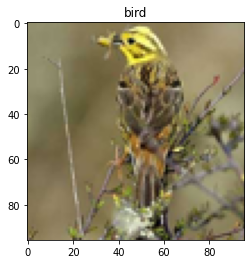

In [3]:
import matplotlib.pyplot as plt
import numpy as np

check_img = np.transpose(train_ds.data[0], (1,2,0))
plt.title(train_ds.classes[train_ds.labels[0]])
plt.imshow(check_img)

###Normalize transformation

In [4]:
# normalize transformation을 적용하기 위해 평균, 표준편차 계산
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [5]:
# transformation 객체 생성
from torch.utils.data import DataLoader

train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

# apply transforamtion
train_ds.transform = train_transformation
valid_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

### 모델 구축

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)

In [ ]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다. 
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

In [9]:
# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가합니다. 정규화 효과가 있습니다. 
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [7]:
class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=10, init_weights=True):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    self.maxpool1 = nn.MaxPool2d(3, 2, 1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(3, 2, 1)
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(3, 2, 1)
    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

    # auxiliary classifier

    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

    # auxiliary classifier

    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(3, 2, 1)
    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(7, 1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
        self.aux1 = InceptionAux(512, num_classes)
        self.aux2 = InceptionAux(528, num_classes)
    else:
        self.aux1 = self.aux2 = None

    # weight initialization
    if init_weights:
        self._initialize_weights()

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)

    if self.aux_logits and self.training:
        aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    if self.aux_logits and self.training:
        aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)

    x = x.view(x.shape[0], -1)

    x = self.dropout(x)
    x = self.fc1(x)
    
    if self.aux_logits and self.training:
        return x, aux1, aux2
    else:
        return x 
    